 ## A simple convolutional neural net for classification of MNIST dataset

File my_batch contains class MnistBatch(Batch) whith a simple CNN model named 'convy' and several methods:
 - load for loading data
 - train_convy which trains convy model
 - update_stats 
 - predict
 - shift_flattened_pic which applies random shift to every pic in the batch

In [1]:
import os
import sys
import blosc

import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tqdm import tqdm

sys.path.append("..")
from dataset import DatasetIndex, Dataset
from my_batch import MnistBatch
from my_batch import draw_stats, draw_digit

## Load data

In [2]:
%matplotlib inline
%env CUDA_VISIBLE_DEVICES=[]
src ='C:\\Users\\Dari\\Documents\\az_training\\task_03'

with open(os.path.join(src, 'mnist_pics.blk'), 'rb') as file:
    full_imgs = blosc.unpack_array(file.read())
    
with open(os.path.join(src, 'mnist_labels.blk'), 'rb') as file:
    full_labs = blosc.unpack_array(file.read())
    
src = (full_imgs, full_labs)

env: CUDA_VISIBLE_DEVICES=[]


## Create dataset using MnistBatch

In [3]:
LEN_MNIST = 65000
indy = DatasetIndex(np.arange(LEN_MNIST))

mnistset = Dataset(indy, batch_class=MnistBatch)
mnistset.cv_split([0.9, 0.1])

bch = MnistBatch(indy.create_subset(indy.indices[1:5]))

### Create session

In [4]:
sess = tf.Session()
sess.run(tf.global_variables_initializer())
stats = []

## Train on the original data

In [5]:
# pipeline for train
ppl = (mnistset.train.pipeline().
       load(src=src, fmt='ndarray').
       train_convy(sess))

# pipeline for test
ppl_test = (mnistset.test.pipeline().
            load(src=src, fmt='ndarray').
            update_stats(sess, stats))

In [6]:
for i in tqdm(range(400)):
    ppl.next_batch(100, n_epochs=None)
    ppl_test.next_batch(100, n_epochs=None)

100%|████████████████████████████████████████████████████████████████████████████████| 400/400 [00:31<00:00, 12.62it/s]


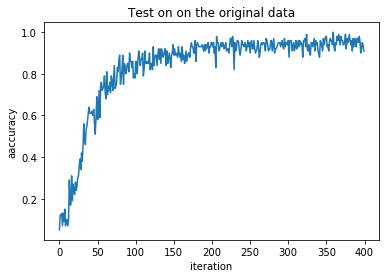

In [7]:
draw_stats(stats, 'Test on on the original data')

## Test on shifted data

In [8]:
ppl_test_shift = (mnistset.test.pipeline().
            load(src=src, fmt='ndarray').
            shift_flattened_pic().
            update_stats(sess, stats))

In [9]:
for i in tqdm(range(400)):
    ppl_test_shift.next_batch(100, n_epochs=None)

100%|████████████████████████████████████████████████████████████████████████████████| 400/400 [00:19<00:00, 20.59it/s]


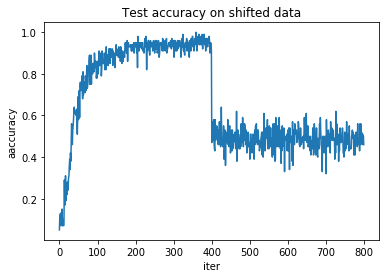

In [10]:
draw_stats(stats, 'Test on on the shifted data')

So we see that a model trained on the original data performs poorly on the shifted data. Let's see where exactly it makes mistakes: 

In [11]:
pics = []
y_true = []
y_predict = []
probs = []

ppl_results = (mnistset.test.pipeline().
    load(src=src, fmt='ndarray').
    shift_flattened_pic().
    predict(sess, pics, y_true, y_predict, probs))

In [12]:
ppl_results.next_batch(100, n_epochs=None)

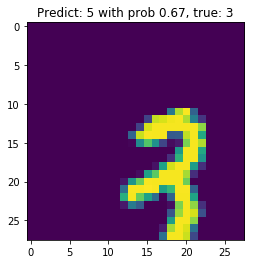

In [13]:
draw_digit(pics,y_predict, y_true, probs, answer=False)

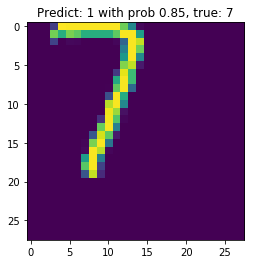

In [18]:
draw_digit(pics,y_predict, y_true, probs, answer=False)

## Train on shifted data

In [19]:
# pipeline for train
ppl_shift = (mnistset.train.pipeline().
       load(src=src, fmt='ndarray').
       shift_flattened_pic().
       train_convy(sess))

In [20]:
for i in tqdm(range(400)):
    ppl_shift.next_batch(100, n_epochs=None)
    ppl_test_shift.next_batch(100, n_epochs=None)

100%|████████████████████████████████████████████████████████████████████████████████| 400/400 [00:52<00:00,  7.58it/s]


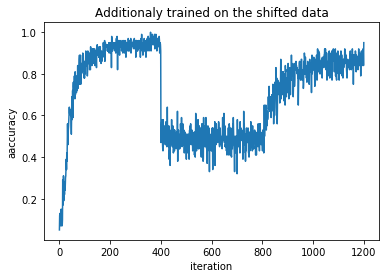

In [21]:
draw_stats(stats, 'Additionaly trained on the shifted data')

So we see that it's much better now.

Let's have a look on the digits:

In [22]:
pics = []
y_true = []
y_predict = []
probs = []
ppl_results = (mnistset.test.pipeline().
    load(src=src, fmt='ndarray').
    shift_flattened_pic().
    predict(sess, pics, y_true, y_predict, probs))

In [23]:
ppl_results.next_batch(100, n_epochs=None)

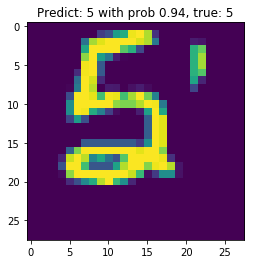

In [48]:
draw_digit(pics,y_predict, y_true, probs, answer=True)

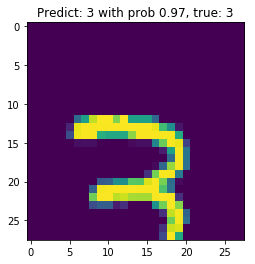

In [50]:
draw_digit(pics,y_predict, y_true, probs, answer=True)

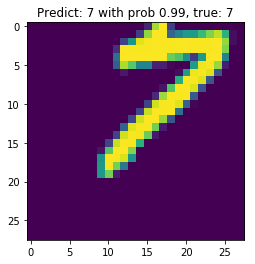

In [52]:
draw_digit(pics,y_predict, y_true, probs, answer=True)

In [53]:
print ('Average accuracy on shifted data: %.2f %%' % (100.0*np.mean(stats[800:])))

Average accuracy on shifted data: 79.75 %
